In [1]:
ls

 Volume in drive C is OS
 Volume Serial Number is C803-CD91

 Directory of C:\Users\Miya\OneDrive\financial-programming\files\financial programming-HOMEWORK\2HFT

12/17/2016  09:00 PM    <DIR>          .
12/17/2016  09:00 PM    <DIR>          ..
12/17/2016  04:18 PM    <DIR>          .ipynb_checkpoints
12/09/2016  10:24 PM           216,053 2HFT.pdf
12/17/2016  08:53 PM        31,942,656 JNJ.db
12/09/2016  10:24 PM        38,242,798 TAQ_CAT_FEB_2010_trading_.csv
12/09/2016  10:24 PM        23,299,333 TAQ_CAT_QUOTE_0104_2010.csv
12/09/2016  10:24 PM        17,621,773 TAQ_JNJ_1004_1015_2010_trading_.csv
12/17/2016  08:53 PM        24,177,271 TAQ_JNJ_1004_1015_2010_trading_normal_hours.csv
12/17/2016  09:00 PM           169,518 Untitled.ipynb
               7 File(s)    135,669,402 bytes
               3 Dir(s)  81,777,041,408 bytes free


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
with open('TAQ_CAT_FEB_2010_trading_.csv') as f:
    content = f.read()
    data = content.split('\n')
    columns = list(filter(lambda x:x!='',data[0].split(' '))) 

In [3]:
columns

['DATE', 'Hour', 'Min', 'Sec', 'PRICE', 'SIZE']

In [4]:
import sqlite3 as lite
con = lite.connect('cat.db')
with con:
    cur = con.cursor()
    cur.execute('drop table if exists cat')
    create_table_query = 'create table cat' + '(date,hour,minute,second,price,volume)'
    cur.execute(create_table_query)

In [5]:
file_length = len(data)
for i in range(1, file_length):
    row = list(filter(lambda x:x!='',data[i].split(' ')))
    query = '''Insert into '''
    cur.execute('''Insert into cat values (?,?,?,?,?,?)''', row)

# Normal Transaction Window

In [6]:
with con:
    cur = con.cursor()
    cur.execute('drop table if exists normal')
    cur.execute("""create table normal as select * from cat where hour||minute >= '930' OR hour||minute <= '1600'""")
    cur.execute("""select * from normal""")
    all_data = cur.fetchall()

In [7]:
import pandas as pd
normal_df = pd.DataFrame(all_data,columns = columns)
normal_df.columns = ['date','hour','minute','second','price','volume']
normal_df['volume'] = normal_df['volume'].astype(float)
normal_df['price'] = normal_df['price'].astype(float)
normal_df['time'] = normal_df['date']+normal_df['hour']+normal_df['minute']+normal_df['second']
normal_df['time'] = pd.to_datetime(normal_df['time'],format = '%Y%m%d%H%M%S')

In [8]:
normal_df.head()

,date,hour,minute,second,price,volume,time
0,20100201,9,30,00,52.82,4528.0,2010-02-01 09:30:00
1,20100201,9,30,00,52.82,4528.0,2010-02-01 09:30:00
2,20100201,9,30,04,52.85,5.0,2010-02-01 09:30:04
3,20100201,9,30,08,52.83,83300.0,2010-02-01 09:30:08
4,20100201,9,30,08,52.86,200.0,2010-02-01 09:30:08


# Visualize the first/last 5000 transactions

In [9]:
first5000 = normal_df.ix[:5000,:]
last5000 = normal_df.iloc[-5000:]
first5000_filtered = first5000[first5000['volume'] < 2000]
last5000_filtered = last5000[last5000['volume'] < 2000]

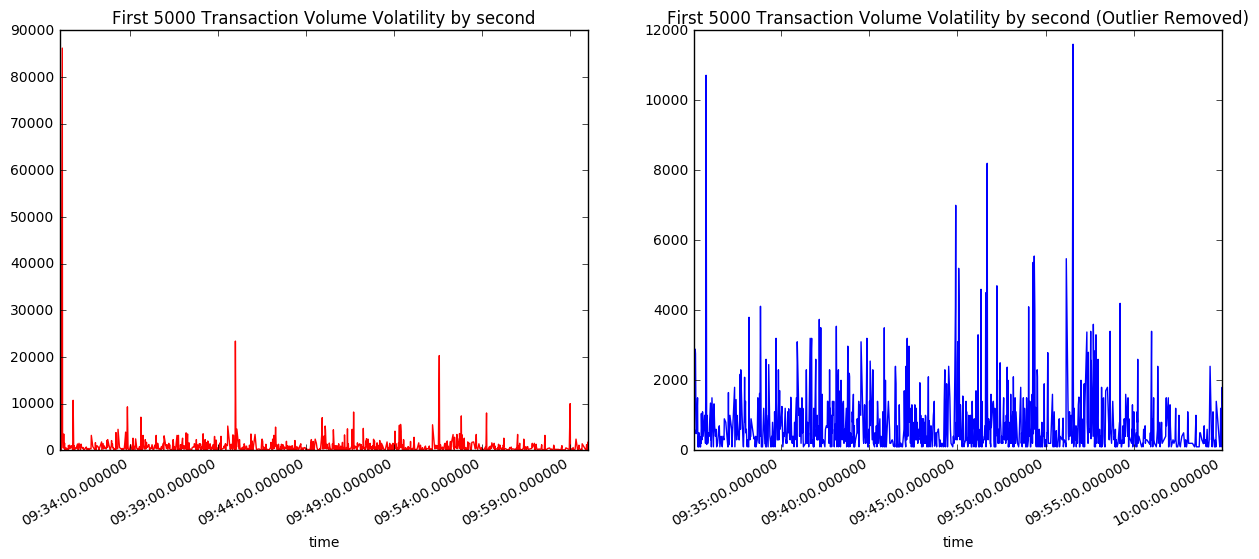

In [10]:
fig, axs = plt.subplots(1,2)
first5000.groupby('time').sum()['volume'].plot(title = 'First 5000 Transaction Volume Volatility by second',
                                               figsize=(15,6),color = 'red',
                                              ax = axs[0])
first5000_filtered.groupby('time').sum()['volume'].plot(title = 'First 5000 Transaction Volume Volatility by second (Outlier Removed)',
                                                        figsize=(15,6),color = 'blue',
                                                       ax = axs[1])

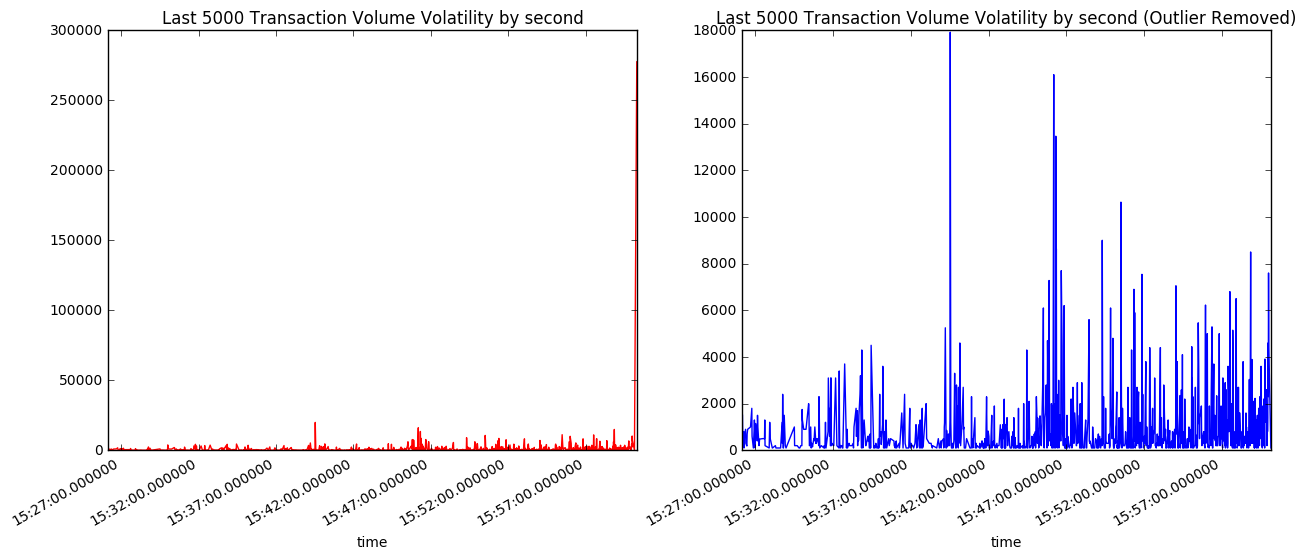

In [11]:
fig, axs = plt.subplots(1,2)
last5000.groupby('time').sum()['volume'].plot(title = 'Last 5000 Transaction Volume Volatility by second',
                                               figsize=(15,6),color = 'red',
                                              ax = axs[0])
last5000_filtered.groupby('time').sum()['volume'].plot(title = 'Last 5000 Transaction Volume Volatility by second (Outlier Removed)',
                                                        figsize=(15,6),color = 'blue',
                                                       ax = axs[1])

# Price change

In [12]:
price_change = list(normal_df['price'][:-1].values - normal_df['price'][1:].values)
print("%d times price change" % (len(price_change) - price_change.count(0)))

318065 times price change


In [13]:
changed_price = list(filter(lambda x: x[1]!=0, list(enumerate(price_change))))

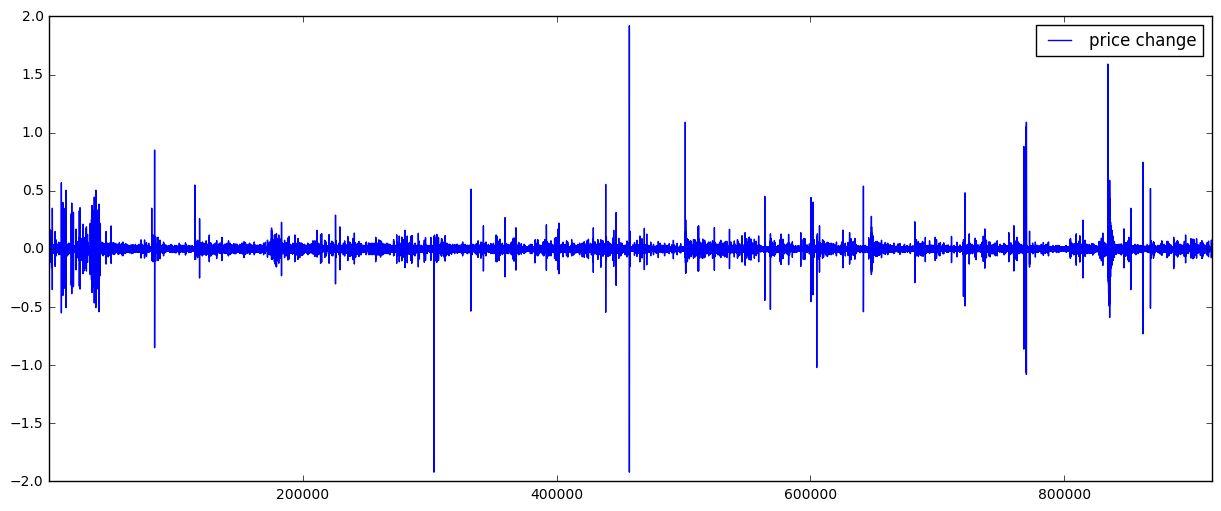

In [14]:
x = list(map(lambda x:x[0],changed_price))
y = list(map(lambda x:x[1],changed_price))
plt.figure(figsize=(16,5))
pd.DataFrame(data = y, index = x,columns = ['price change']).plot(figsize=(15,6))

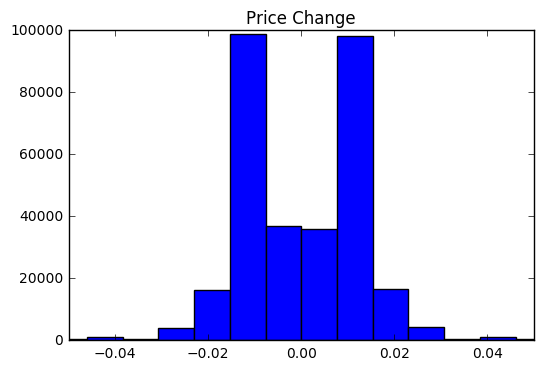

In [15]:
plt.hist(y,bins = 500)
plt.xlim(-0.05,0.05)
plt.title('Price Change')

# Partition trading time

In [16]:
intervals = ['5Min','10Min','30Min','60Min']

In [17]:
for interval in intervals:
    grouped = normal_df.groupby(pd.TimeGrouper(key = 'time',freq=interval)).aggregate(np.sum)
    S_i = grouped['price']
    S_i_minus_1 = grouped['price'].shift(1)
    grouped['log_return'] = np.log(S_i/S_i_minus_1)
    grouped.to_csv('TAQ_JNJ_1004_1015_2010_'+interval+'trading_unit.csv')

# Section Volatility

In [18]:
for interval in intervals:
    grouped = normal_df.groupby(pd.TimeGrouper(key = 'time',freq=interval)).aggregate(np.mean)
    S_i = grouped['price']
    S_i_minus_1 = grouped['price'].shift(1)
    grouped['log_return'] = np.log(S_i/S_i_minus_1)
    n = len(grouped)
    x = (1/(n-1))*np.sum(np.log(S_i/S_i_minus_1)*np.log(S_i/S_i_minus_1))
    y = 1/((n-1)*n)*np.sum(np.log(S_i/S_i_minus_1))*np.sum(np.log(S_i/S_i_minus_1))
    section_vol = np.sqrt(x-y)
    vol = grouped['volume']
    x = (1/(n-1))*np.sum(vol*vol)
    y = 1/((n-1)*n)*np.sum(vol)*np.sum(vol)
    vol_section = np.sqrt(x-y)
    u_mean = np.mean(np.log(S_i/S_i_minus_1))
    skewness_0 = np.sum((np.log(S_i/S_i_minus_1)-u_mean)**3)
    skewness = n*skewness_0/((n-1)*(n-2)*section_vol**3)
    kurtosis_0 = np.sum((np.log(S_i/S_i_minus_1)-u_mean)**4)
    kurtosis = (n*skewness_0/(n*section_vol**4))-3
    print("""FOR %s TRADING UNIT:\n
    section volatility is %s \n
    volume section standard deviation is %s\n
    skewness is %s\n
    kurtosis is %s\n"""%(interval, section_vol,vol_section, skewness, kurtosis))      

FOR 5Min TRADING UNIT:

    section volatility is 0.000746907449913 

    volume section standard deviation is 1591.55195303

    skewness is -0.488962339617

    kurtosis is -4763230.5161

FOR 10Min TRADING UNIT:

    section volatility is 0.000986452951726 

    volume section standard deviation is 2247.60204773

    skewness is 0.0576576225139

    kurtosis is 212577.645023

FOR 30Min TRADING UNIT:

    section volatility is 0.00166678138765 

    volume section standard deviation is 3881.52780991

    skewness is 0.0752706305513

    kurtosis is 54684.950248

FOR 60Min TRADING UNIT:

    section volatility is 0.00236443651753 

    volume section standard deviation is 5465.37334888

    skewness is 0.473319877638

    kurtosis is 121108.343367

